In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

from sklearn import feature_selection, feature_extraction, manifold, decomposition, linear_model, cluster
from sklearn import linear_model, svm, neural_network, model_selection, preprocessing, tree, ensemble
from sklearn import gaussian_process, pipeline, metrics, dummy

from scipy.cluster import hierarchy
from scipy.spatial import distance

import eli5
import xgboost
import skopt

from skopt.space import Integer, Real, Categorical

from xgboost import XGBClassifier

In [2]:
train = pd.read_csv("data/data_set_ALL_AML_train.csv", delimiter=",")
test = pd.read_csv("data/data_set_ALL_AML_independent.csv", delimiter=",")
actual = pd.read_csv("data/actual.csv")

In [3]:
X = (train.drop(["Gene Description", "Gene Accession Number"], axis=1)
          .drop([col for col in train.columns if "call" in col], axis=1)).values.T

X_test = (test.drop(["Gene Description", "Gene Accession Number"], axis=1)
               .drop([col for col in test.columns if "call" in col], axis=1)).values.T

labels = actual.cancer.values
encoded_labels = preprocessing.LabelEncoder().fit_transform(labels)

y = encoded_labels[:X.shape[0]]
y_test = encoded_labels[X.shape[0]:]

descriptions = np.array(list(map(lambda x: x[:13], train["Gene Description"])))

In [4]:
X.shape, X_test.shape, y.shape, y_test.shape

((38, 7129), (34, 7129), (38,), (34,))

In [5]:
def plot(idx, xticks=False):
    plt.figure(figsize=(15,10))
    
    if xticks:
        plt.xticks(range(len(idx)), descriptions[idx], rotation="vertical")
        
    plt.yticks(range(len(X)), labels)
    plt.imshow(X[:,idx], cmap="magma")
    
    mask = np.ones_like(X)
    mask[(encoded_labels == 1)[:X.shape[0]], :] = 0
    plt.imshow(mask[:,:len(idx)], alpha=0.15, cmap="gray")

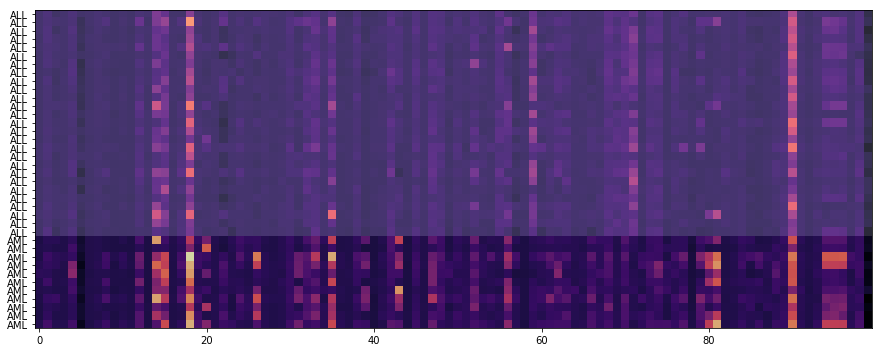

In [6]:
num = 100

kbest = feature_selection.SelectKBest(k=num)
X_sel = kbest.fit_transform(X, y)
X_sel.shape

plot(kbest.get_support(True))

Using ExtraTrees feature importance classifier

0.6176470588235294


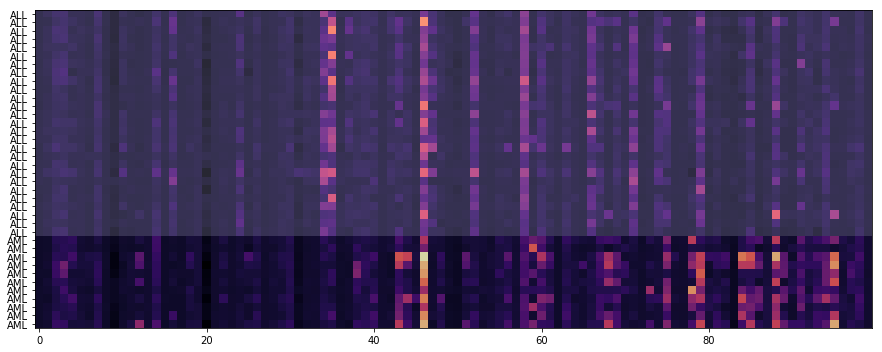

In [9]:
cls = ensemble.ExtraTreesClassifier(n_estimators=500)
cls.fit(X, y)

important = np.argsort(cls.feature_importances_)[-100:]
plot(important)

print(cls.score(X_test, y_test))

In [17]:
lm = linear_model.LogisticRegressionCV().fit(X[:,important], y)
lm.score(X_test[:, important], y_test)

0.6176470588235294

In [18]:
eli5.show_weights(lm, top=10)

In [ ]:
XGBClassifier().fit(X, y).score(X_test, y_test)

In [19]:
opt = skopt.BayesSearchCV(svm.SVC(),
                   {
                       "C": Real(1e-6, 1e6, prior="log_uniform"),
                       "gamma": Real(1e-6, 1e6, prior="log_uniform"),
                       "degree": Integer(1, 8),
                       "kernel": Categorical(["linear", "poly", "rbf"])
                   }, n_jobs=8)

opt.fit(X, y)
# opt.score(X_test, y_test)

C:\dev\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_iter=50, n_jobs=8, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
       refit=True, return_train_score=False, scoring=None,
       search_spaces={'C': Real(low=1e-06, high=1000000.0, prior='log_uniform', transform='identity'), 'gamma': Real(low=1e-06, high=1000000.0, prior='log_uniform', transform='identity'), 'degree': Integer(low=1, high=8), 'kernel': Categorical(categories=('linear', 'poly', 'rbf'), prior=None)},
       verbose=0)

In [ ]:
pipe = pipeline.Pipeline([
    ("selection", feature_selection.SelectKBest()),
    ("model", svm.SVC())
])

linear_svm_search = {
    "selection__k": Integer(20, X.shape[0]),
    "model": [svm.LinearSVC()]
}

svc_search = {
    "selection__k": Integer(20, X.shape[0]),
    "model": [svm.SVC()],
    "model__C": Real(1e-6, 1e6, prior="log_uniform"),
    "model__gamma": Real(1e-6, 1e6, prior="log_uniform"),
    "model__degree": Integer(1, 8),
    "model__kernel": Categorical(["linear", "poly", "rbf"])
}

opt = skopt.BayesSearchCV(pipe, [(linear_svm_search, 10), (svc_search, 100)])

# opt.fit(X, y).score(X_test, y_test)

In [ ]:
# opt.best_params_

In [11]:
%load_ext rpy2.ipython

In [21]:
%%R
install.packages("discretization")
library("discretization")

In [ ]:
# %%R -i X
# xx <- mdlp(X)

In [22]:
model_selection.cross_val_score(svm.SVC(), X, y, cv=10)

array([0.6       , 0.75      , 0.75      , 0.75      , 0.75      ,
       0.75      , 0.75      , 0.66666667, 0.66666667, 0.66666667])

In [ ]:
z_dim = 100

tf.reset_default_graph()

img = tf.placeholder(tf.float32, shape=[None, input_shape], name="img")

def encoder(img):
    with tf.variable_scope("encoder"):
        hidden = tf.layers.dense(img, 500, activation=tf.nn.relu)
        hidden = tf.layers.dense(hidden, 500, activation=tf.nn.relu)
    
    return hidden

def decoder(z):
    with tf.variable_scope("decoder"):
        hidden = tf.layers.dense(z, 500, activation=tf.nn.relu)
        hidden = tf.layers.dense(hidden, 500, activation=tf.nn.relu)
        
    out = tf.layers.dense(hidden, input_shape, name="output")    
    return out

z = encoder(img)
out = decoder(z)

loss = tf.losses.mean_squared_error(img, out)

global_step = tf.train.create_global_step()
training = tf.train.AdamOptimizer().minimize(loss, global_step=global_step, name="training")

summary_writer = tf.contrib.summary.create_file_writer("logs", flush_millis=5*1000)

with summary_writer.as_default(), tf.contrib.summary.record_summaries_every_n_global_steps(100):
    summaries = [
        tf.contrib.summary.scalar("loss", loss)
    ]
    
try:
    sess.close()
except NameError:
    print("No session defined, continuing.")

sess = tf.InteractiveSession()

with summary_writer.as_default():
    tf.contrib.summary.initialize(session=sess, graph=tf.get_default_graph())

init = tf.global_variables_initializer()
sess.run(init)

In [ ]:
for _ in range(10000):
    sess.run([training, summaries], feed_dict={img: X})

In [ ]:
X_embed = sess.run(z, feed_dict={img: X})
X_test_embed = sess.run(z, feed_dict={img: X_test})

In [ ]:
svm.LinearSVC().fit(X_embed, y).score(X_test_embed, y_test)

In [ ]:
dummy.DummyClassifier().fit(X_embed, y).score(X_test_embed, y_test)

In [ ]:
linear_model.LogisticRegression(penalty="l1", solver="liblinear", class_weight="balanced", C=.0001).fit(X_embed, y).score(X_test_embed, y_test)

In [ ]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# References

- Golub, Todd R., et al. "Molecular classification of cancer: class discovery and class prediction by gene expression monitoring." science 286.5439 (1999): 531-537.